# Photon Count Histograms

In [169]:
import os
import importlib
import sys


working_directory = "D:/PhD_Trieste/Simulations/Imaging_Simulation"

if os.getcwd()!= working_directory:
    os.chdir(working_directory)  
    
print(working_directory)

import Simulations_Libraries.trajectory_library as trajlib
import numpy as np
import matplotlib.pyplot as plt
from Camera import *
from scipy.stats import poisson
from scipy.optimize import curve_fit
import Simulations_Libraries.general_library as genlib
import ArQuS_analysis_lib as anslib
import matplotlib.cm as cm
from tqdm import tqdm


%matplotlib

plt.ion()

D:/PhD_Trieste/Simulations/Imaging_Simulation
Using matplotlib backend: module://matplotlib_inline.backend_inline


In [170]:
'''------------------------------Parameters-------------------------------------'''
trapType = 'Tweezer'
trapFreq_r = 2*np.pi*140e3
isotope = 174 
baseAtom = trajlib.Ytterbium(0,0,0, 0,0,0,isotope=isotope)
trapDuration = 8e-6
freeFlightTime = 0e-6
acquisitionDuration = 7e-6
experimentDuration = trapDuration + freeFlightTime
imagingOption = 'Tweezer'
nOfAtoms = 1

initialT = 20e-6

In [177]:


    
'''-------------------------------folders and files------------------------------'''
extraWord = f'_Temperature_{np.round(initialT*1e6)}uK'
pictureFolder = working_directory +  f"/simulationImages/{trapType}/Yt{isotope}_{int(experimentDuration*1e6)}us_{trapType}Duration{trapDuration*1e6}us_freeFlight{freeFlightTime*1e6}us_imagingTime{acquisitionDuration*1e6}us_imaging{imagingOption}_{nOfAtoms}" + extraWord
simulationFolder = working_directory + f"/simulationImages/{trapType}/Yt{isotope}_{int(experimentDuration*1e6)}us_{trapType}Duration{trapDuration*1e6}us_freeFlight{freeFlightTime*1e6}us_imagingTime{acquisitionDuration*1e6}us_imaging{imagingOption}_{nOfAtoms}" + extraWord + "/simulation/"
baseFileName = "simulation"
blurFolder = "bigBlurs/"       # PSF along the camera axis
backgroundNoiseFolder = "Orca_testing/shots_free_space/"
repeat = 0
stop = False

Images = []
positionX = []
positionY = []
positionZ = []

pixelSize = 4.6e-6
magnification = 8


conversionFactor = pixelSize/magnification
    
while not stop:
    fileName = f"{baseFileName}_{repeat}.h5"
    imageFileName = f"{pictureFolder}/{fileName}"
    simulationFileName = f"{simulationFolder}/{fileName}"
    exp = trajlib.experiment()
    if not os.path.exists(simulationFileName):
        stop = True
    else:
        repeat +=1
        if repeat % 100 == 0:
            print(f"Acquired Images: {repeat}", end="\r")

        Images.append(load_h5_image(path = imageFileName, internalPath = None, returnMetadata = False))
        metadata = exp.loadAcquisition(simulationFileName)
           
    
        trajectoriesX = exp.lastPositons[:,:,0] 
        trajectoriesY = exp.lastPositons[:,:,1] 
        trajectoriesZ = exp.lastPositons[:,:,2]
        for i in range(trajectoriesX.shape[1]):
            positionX.append(trajectoriesX[:,i][~np.isnan(trajectoriesX[:,i])][-1])
            positionY.append(trajectoriesY[:,i][~np.isnan(trajectoriesY[:,i])][-1])
            positionZ.append(trajectoriesZ[:,i][~np.isnan(trajectoriesZ[:,i])][-1])
                

Images = np.asarray(Images)

positionX = np.array(positionX)
positionY = np.array(positionY)
positionZ = np.array(positionZ)

positionPixelX = positionX/conversionFactor+ Images.shape[1]/2 -0.5
positionPixelY = positionY/conversionFactor+ Images.shape[1]/2 -0.5

positionPixelX = np.round(positionPixelX)
positionPixelY = np.round(positionPixelY)

Acquired Images: 10000

In [173]:
size = 3
clim = 4
show_stuff = False
print_stuff = True

corners, patches = anslib.make_rois(size = size, centers = np.array([positionPixelX,positionPixelY]))
tweezersRois = []
sumRoi = []

for i in tqdm(range(len(positionX)), desc="Analysing Data",mininterval=1,maxinterval=30):
    
    Roi = Images[i,corners[0,i]:corners[0,i]+size,corners[1,i]:corners[1,i]+size]
    sumRoi.append(np.sum(Roi))
    tweezersRois.append(Roi)

sumRoi = np.asarray(sumRoi)
tweezersRois = np.asarray(tweezersRois)


Analysing Data: 100%|████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 118511.62it/s]


Tweezer filling P = 0.9899999999769957
Problem in the histogram fit


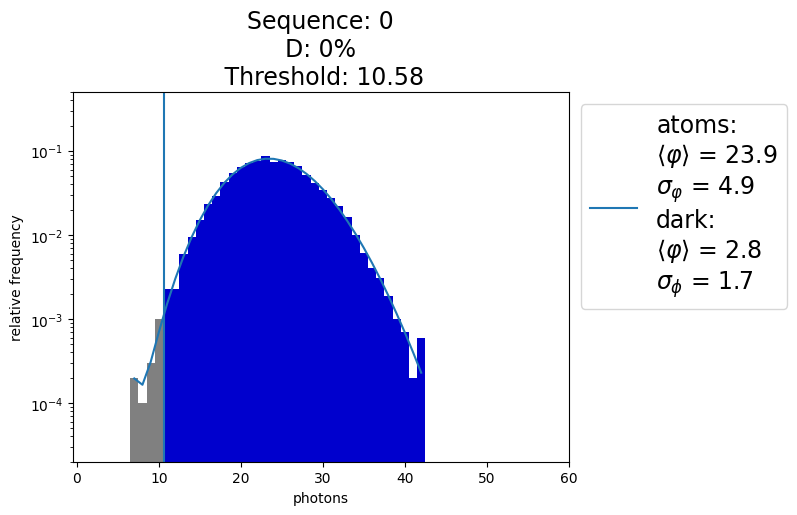

In [174]:
x_th, F,fit_params,_ = Ar.find_threshold(sumRoi,sequence_indexes = 0,x_lim = 60,logscale=True, poisson = True, y_lim = 2e-5)